In [1]:
import bead_util as bu
import glob, os
import correlation, h5py
import numpy as np
from matplotlib.mlab import psd
import matplotlib.pyplot as plt
from correlation import charge_of_electron
from matplotlib.rcParams import update

distance_between_plates = 0.001 # meters

In [2]:
calib_path = "/data/20170622/bead4_15um_QWP/charge11"
data_path = "/data/20170622/bead4_15um_QWP/dipole27_Y" # this has the W
file_list = glob.glob(os.path.join(data_path, '*.h5'))
calib_list = glob.glob(os.path.join(calib_path, '*.h5'))

In [42]:
def getData(fname):
    """ assumes fname ends with a '.h5' 
        returns unitless data from file """
    gain, ACamp = correlation.getGainAndACamp(fname)
    f = h5py.File(fname, 'r')
    dset = f['beads/data/pos_data']
    dat = np.transpose(dset) # all this data is in volts
    dat = dat * 10./(2**15 - 1)
    x = dat[:,0]/gain
    x_data = ((x - np.average(x))/float(len(x))) # V

    drive = dat[:,7]
    drive_data = (drive - np.average(drive))/np.std(drive) # normalized, unitless drive

    Fs = dset.attrs['Fsamp']
    xpsd, freqs = psd(x_data, Fs = Fs, NFFT = 2**17) # V^2/Hz, Hz

    return x_data, drive_data, ACamp, freqs, xpsd

In [55]:
# Calibrate on one electron
peaks = []
corrs = []
for cname in calib_list:
    x_data, drive_data, acamp, freqs, xpsd = getData(cname)
    binF = freqs[1]-freqs[0]
    N = acamp*charge_of_electron/distance_between_plates # newtons

    drive_frequency = correlation.getFDrive(cname)
    index = np.argmin(np.abs(np.array(freqs)-drive_frequency))
    peak = binF*np.sum(xpsd[index-2:index+3]) # V^2
    peaks.append(np.sqrt(peak)) # V

    oc = np.correlate(x_data, drive_data) # V
    corrs.append(oc[0])

corrs, peaks = zip(*sorted(zip(corrs, peaks)))
end_index = min(5, len(corrs))
c_peak = np.average(peaks[:end_index])/N # V/N
c_corr = np.average(corrs[:end_index])/N # V/N
print c_peak, c_corr

17149651.4371 -8.57623911816e+12


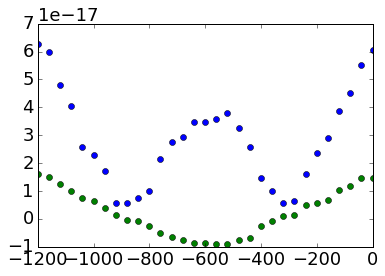

In [56]:
# Get and plot calibrated data
peaks, positions, tf = ([] for i in range(3))
y_or_z = ""
for fname in file_list:
    x_data, drive_data, acamp, freqs, xpsd = getData(fname)
    binF = freqs[1]-freqs[0]
    position, y_or_z = correlation.outputThetaPosition(fname, y_or_z)
    positions.append(position)

    twice_drive_frequency = 2.*correlation.getFDrive(fname)
    index = np.argmin(np.abs(np.array(freqs)-twice_drive_frequency))
    peak = binF*max(xpsd[index-5:index+5]) # V^2
    peaks.append(np.sqrt(peak)/c_peak) # N

    tc = np.correlate(x_data, drive_data**2) # V
    tf.append(tc[0]/c_corr) # N

positions, peaks, tf = zip(*sorted(zip(positions, peaks, tf)))
plt.plot(positions, peaks, 'o')
plt.plot(positions, tf, 'o')
plt.show()

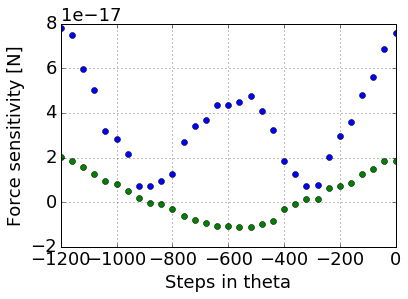

In [12]:
%matplotlib notebook

plt.plot(positions, peaks, 'o')
plt.plot(positions, tf, 'o')

update({'font.size': 18})

plt.xlabel('Steps in theta')
plt.ylabel('Force sensitivity [N]')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


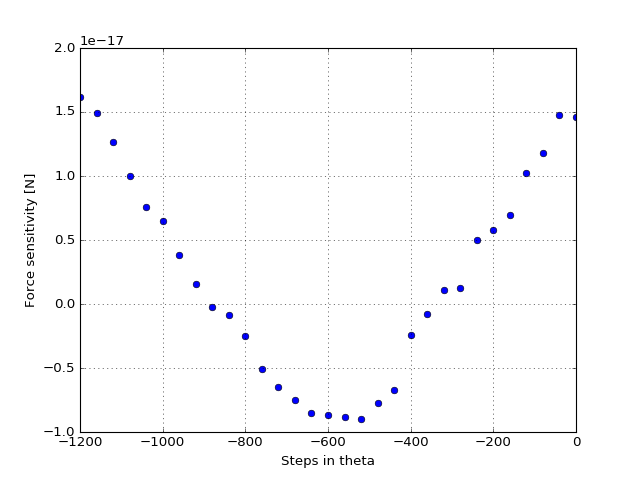

In [58]:
%matplotlib notebook

electrons_per_newton = 456.64874400277552 # got from Plot PSDs

plt.plot(positions, tf, 'o')

plt.xlabel('Steps in theta')
plt.ylabel('Force sensitivity [N]')

plt.grid()
plt.show()

<IPython.core.display.Javascript object>


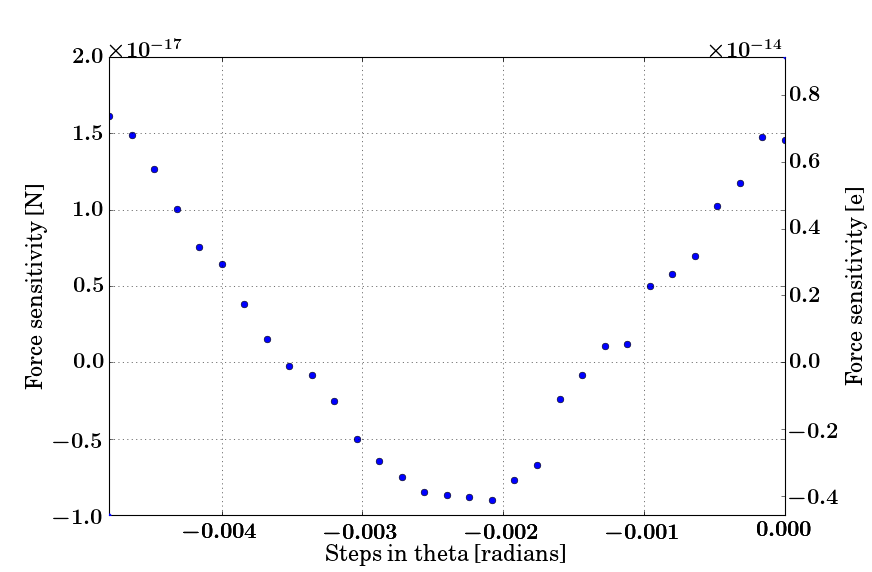

In [69]:
%matplotlib notebook

electrons_per_newton = 456.64874400277552 # got from Plot PSDs
pos_in_radians = np.array(positions)*4.0e-6

psd_fig = plt.figure()

plt.rc('text', usetex=True)
#plt.rc('font', family='serif')
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 20}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.latex.preamble'] = [r'\boldmath']

ax1 = psd_fig.add_subplot(111)

ax1.plot(pos_in_radians, tf, 'bo')

plt.xlim([pos_in_radians[0],pos_in_radians[-1]])
plt.ylim([-1.0e-17,2.0e-17])
plt.ylabel('Force sensitivity [N]', size=20)
plt.legend(prop={'size': 20}, loc=3)

plt.grid()

ax2 = psd_fig.add_subplot(111, sharex=ax1, frameon=False)
ax2.plot([pos_in_radians[0],pos_in_radians[-1]], np.array([-1.0e-17,2.0e-17])*electrons_per_newton, 'b.')
plt.ylim([-1.0e-17*electrons_per_newton,2.0e-17*electrons_per_newton])
ax2.yaxis.tick_right()
#ax2.tick_params(axis='y', which='major', pad=15)
ax2.yaxis.set_label_position("right")
plt.ylabel('Force sensitivity [e]', size=20)

plt.xlim([pos_in_radians[0],pos_in_radians[-1]])
plt.xlabel('Steps in theta [radians]')

plt.show()